In [2]:
!pip install tensorflow==2.15 keras==2.15 --upgrade

In [3]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# 2. Load and Preprocess Dataset
df = pd.read_csv('/content/MicrosoftStock.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [5]:
# Remove duplicate rows if any
df = df.drop_duplicates()

# Remove rows with negative stock prices or volume
num_cols = ['open', 'high', 'low', 'close', 'volume']
for col in num_cols:
    df = df[df[col] >= 0]

# Handle missing values - first check missing
if df.isnull().sum().sum() > 0:
    # Interpolate for time series, else drop if still missing
    df.interpolate(method='time', inplace=True)
    df = df.dropna()

# Remove outliers using IQR for 'close' price
Q1 = df['close'].quantile(0.25)
Q3 = df['close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)
df = df[(df['close'] >= lower_bound) & (df['close'] <= upper_bound)]

In [8]:
df

,index,open,high,low,close,volume,Name
date,,,,,,,
2013-02-08,390198,27.35,27.7100,27.3100,27.55,33318306,MSFT
2013-02-11,390199,27.65,27.9200,27.5000,27.86,32247549,MSFT
2013-02-12,390200,27.88,28.0000,27.7500,27.88,35990829,MSFT
2013-02-13,390201,27.93,28.1100,27.8800,28.03,41715530,MSFT
2013-02-14,390202,27.92,28.0600,27.8700,28.04,32663174,MSFT
...,...,...,...,...,...,...,...
2018-01-09,391436,88.65,88.7272,87.8600,88.22,19484317,MSFT
2018-01-10,391437,87.86,88.1900,87.4100,87.82,18652201,MSFT
2018-01-11,391438,88.13,88.1300,87.2400,88.08,17808877,MSFT


In [9]:
# Feature Engineering - Technical Indicators
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['EMA_20'] = df['close'].ewm(span=20).mean()
rolling_mean = df['close'].rolling(window=20).mean()
rolling_std = df['close'].rolling(window=20).std()
df['Bollinger_High'] = rolling_mean + (rolling_std * 2)
df['Bollinger_Low'] = rolling_mean - (rolling_std * 2)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df.dropna(inplace=True)

In [10]:
# Normalization
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_20', 'EMA_20', 'Bollinger_High', 'Bollinger_Low', 'RSI']
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# 3. Train-Test Split
train_size = int(len(df_scaled)*0.8)
train_df = df_scaled.iloc[:train_size]
test_df = df_scaled.iloc[train_size:]

X = df_scaled.drop(columns=['close'])
y = df_scaled['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

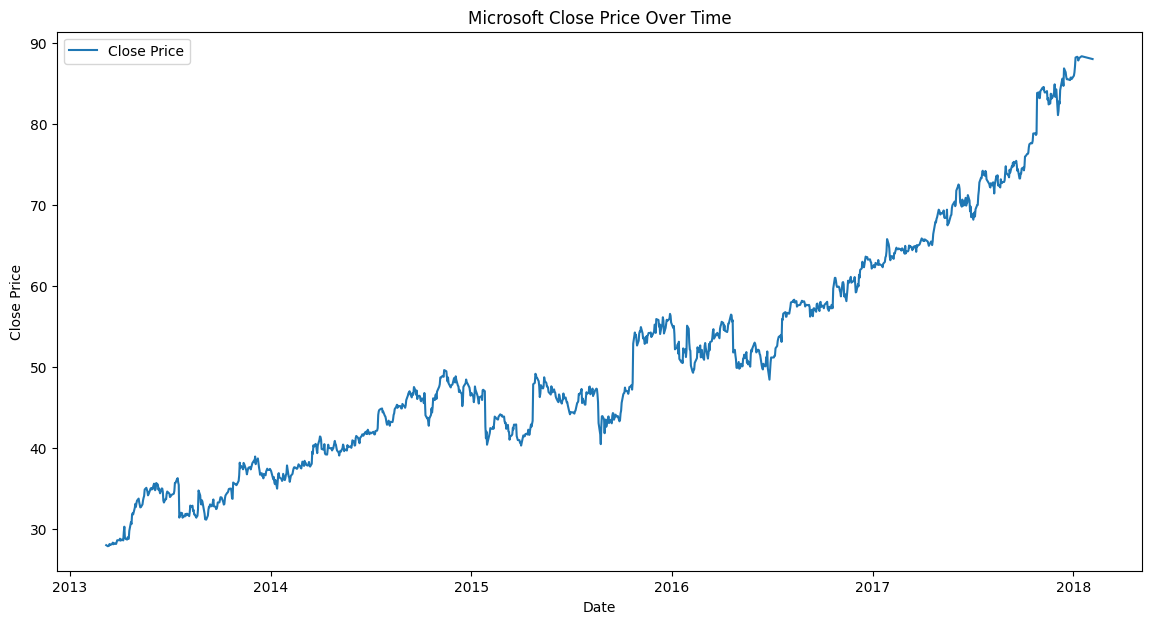

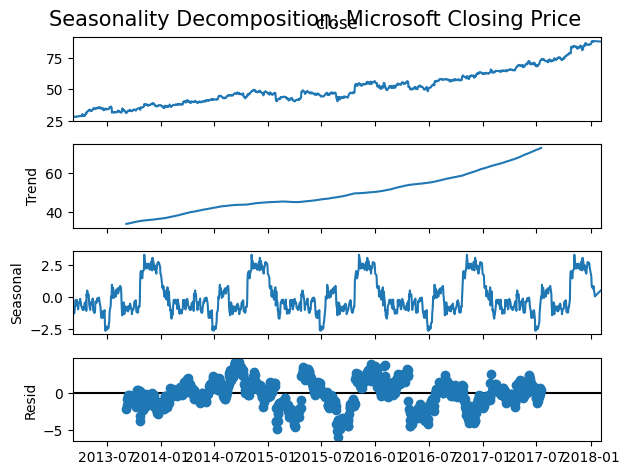

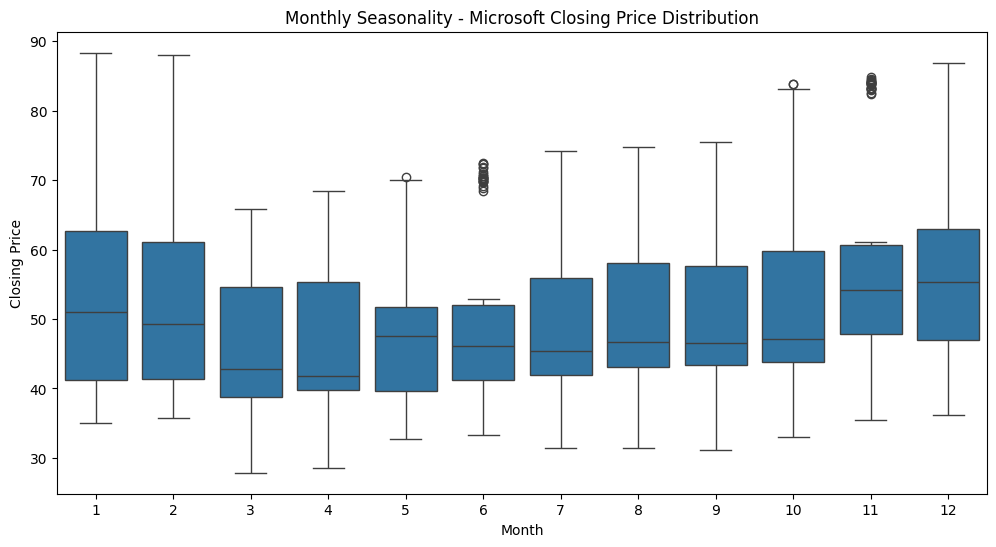

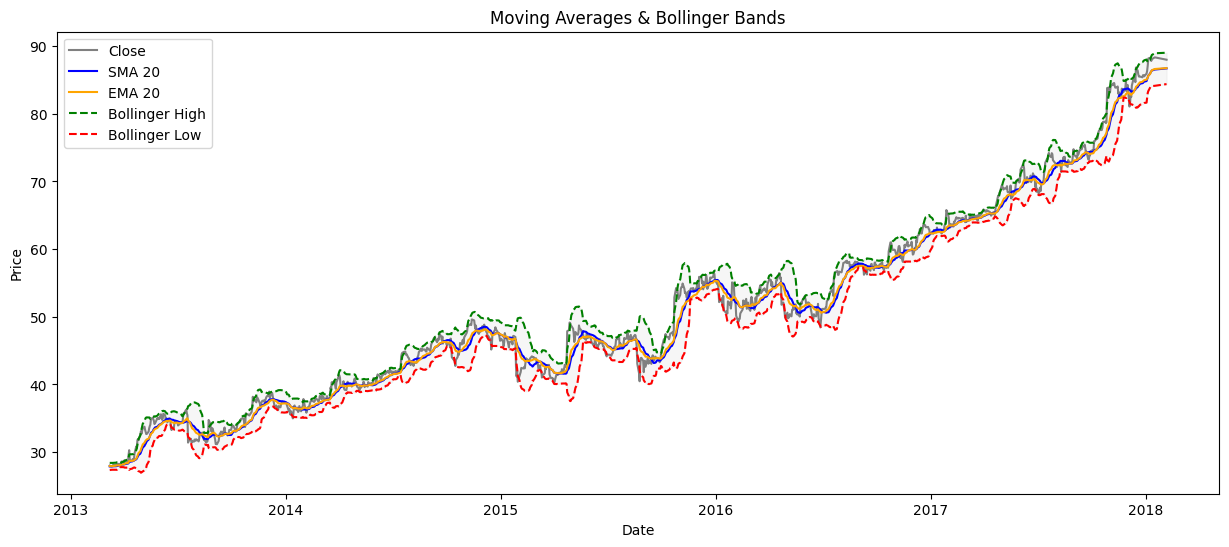

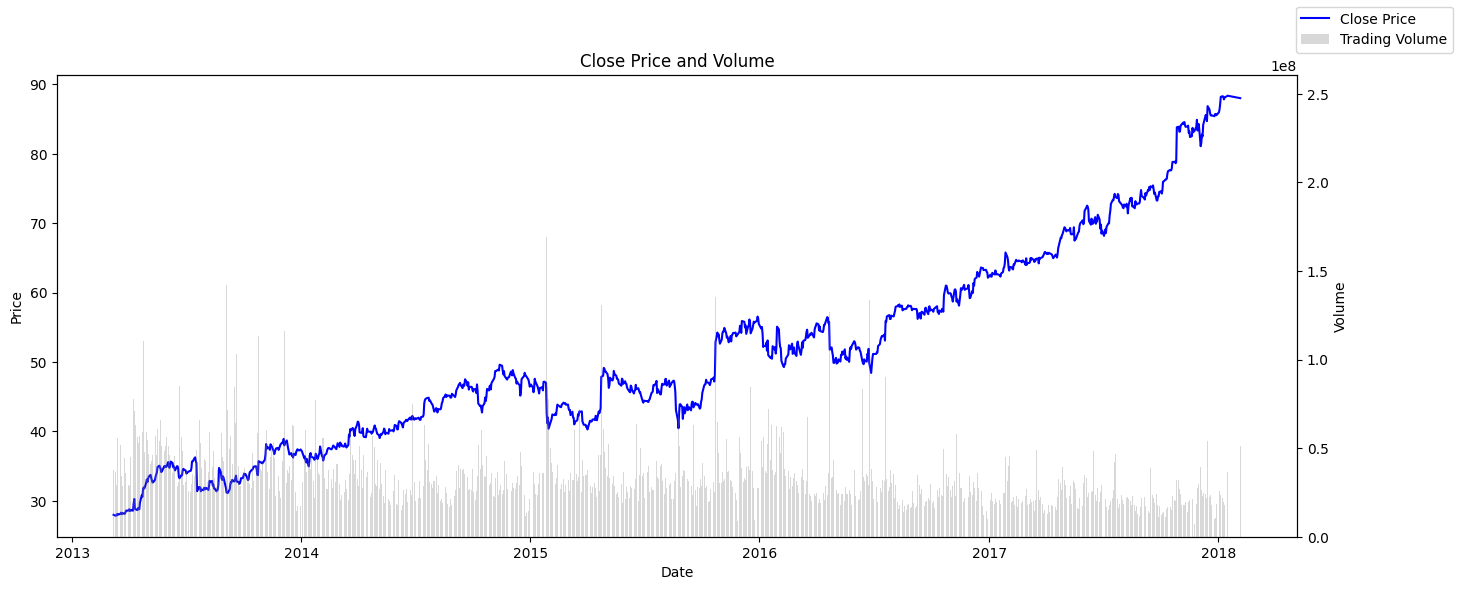

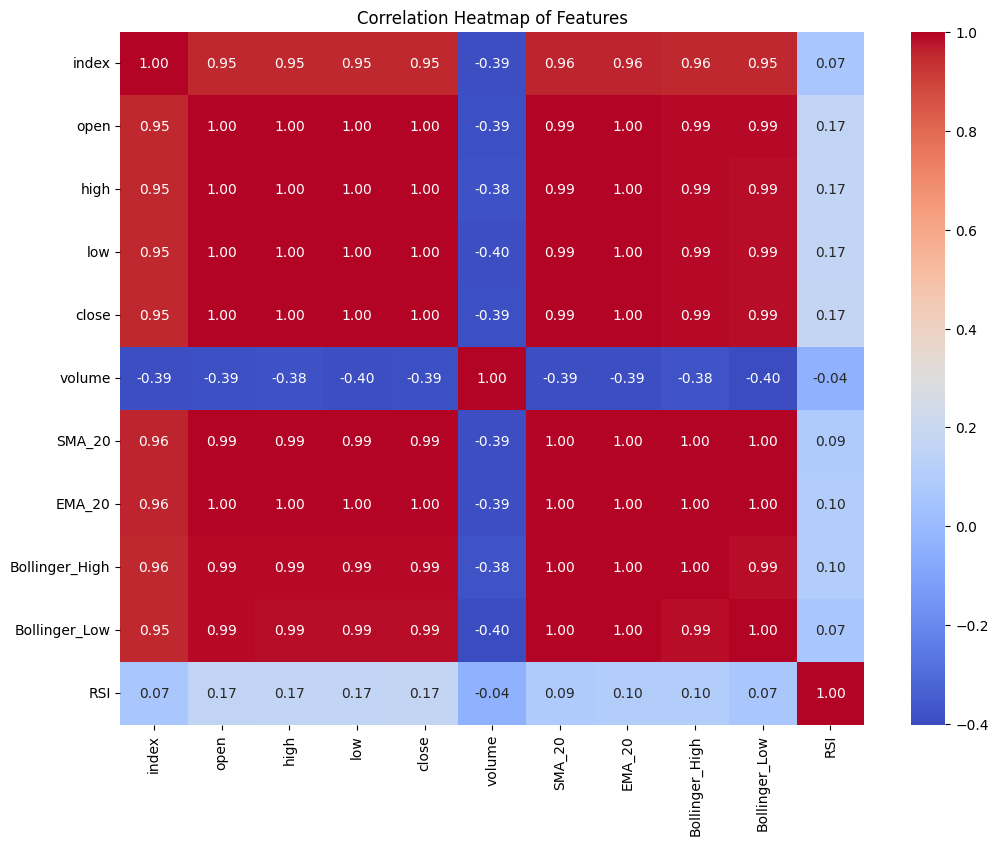

In [11]:
# 4. Exploratory Data Analysis (EDA)
plt.figure(figsize=(14,7))
plt.plot(df.index, df['close'], label='Close Price')
plt.title('Microsoft Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['close'], model='additive', period=252) # 252 is trading days in a year
result.plot()
plt.suptitle('Seasonality Decomposition: Microsoft Closing Price', fontsize=15)
plt.show()

df['month'] = df.index.month
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='close', data=df)
plt.title('Monthly Seasonality - Microsoft Closing Price Distribution')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.show()

plt.figure(figsize=(15,6))
plt.plot(df.index, df['close'], label='Close', color='grey')
plt.plot(df.index, df['SMA_20'], label='SMA 20', color='blue')
plt.plot(df.index, df['EMA_20'], label='EMA 20', color='orange')
plt.plot(df.index, df['Bollinger_High'], label='Bollinger High', linestyle='--', color='green')
plt.plot(df.index, df['Bollinger_Low'], label='Bollinger Low', linestyle='--', color='red')
plt.fill_between(df.index, df['Bollinger_High'], df['Bollinger_Low'], color='lightgray', alpha=0.2)
plt.legend(loc='upper left')
plt.title('Moving Averages & Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(df.index, df['close'], color='blue', label='Close Price')
ax2 = ax1.twinx()
ax2.bar(df.index, df['volume'], color='grey', width=1, label='Trading Volume', alpha=0.3)
ax1.set_title('Close Price and Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2.set_ylabel('Volume')
fig.legend(loc="upper right")
plt.show()

plt.figure(figsize=(12,9))
sns.heatmap(df[[col for col in df.columns if col not in ['month', 'Name']]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

In [12]:
# 5. Model Training & Evaluation

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("Linear Regression:")
print("  MAE:", mean_absolute_error(y_test, lr_pred))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("  R2:", r2_score(y_test, lr_pred))

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest:")
print("  MAE:", mean_absolute_error(y_test, rf_pred))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("  R2:", r2_score(y_test, rf_pred))

# XGBoost
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgbr.fit(X_train, y_train)
xgb_pred = xgbr.predict(X_test)
print("XGBoost:")
print("  MAE:", mean_absolute_error(y_test, xgb_pred))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, xgb_pred)))
print("  R2:", r2_score(y_test, xgb_pred))

Linear Regression:
  MAE: 0.0031716409601172018
  RMSE: 0.004926268594515328
  R2: 0.998322735660756
Random Forest:
  MAE: 0.1622904991361624
  RMSE: 0.20196505784232335
  R2: -1.819147607527642
XGBoost:
  MAE: 0.16106401071758553
  RMSE: 0.2008836726783114
  R2: -1.7890392027855806


In [13]:
# 6. LSTM Preparation
SEQ_LEN = 60  # Look-back window for LSTM

def create_lstm_data(series, seq_len):
    X, Y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        Y.append(series[i+seq_len])
    return np.array(X), np.array(Y)

close_series = df_scaled['close'].values
X_all_lstm, y_all_lstm = create_lstm_data(close_series, SEQ_LEN)
n_train_lstm = train_size - SEQ_LEN
X_train_lstm = X_all_lstm[:n_train_lstm]
y_train_lstm = y_all_lstm[:n_train_lstm]
X_test_lstm = X_all_lstm[n_train_lstm:]
y_test_lstm = y_all_lstm[n_train_lstm:]

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], SEQ_LEN, 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], SEQ_LEN, 1))

# Build & Train LSTM
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN,1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/30
26/26 [==============================] - 8s 138ms/step - loss: 0.0164 - val_loss: 0.0109
Epoch 2/30
26/26 [==============================] - 1s 52ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 3/30
26/26 [==============================] - 1s 52ms/step - loss: 0.0018 - val_loss: 2.6445e-04
Epoch 4/30
26/26 [==============================] - 1s 55ms/step - loss: 0.0017 - val_loss: 9.8503e-04
Epoch 5/30
26/26 [==============================] - 1s 54ms/step - loss: 0.0015 - val_loss: 3.1433e-04
Epoch 6/30
26/26 [==============================] - 1s 52ms/step - loss: 0.0015 - val_loss: 2.6019e-04
Epoch 7/30
26/26 [==============================] - 1s 55ms/step - loss: 0.0016 - val_loss: 6.6559e-04
Epoch 8/30
26/26 [==============================] - 2s 74ms/step - loss: 0.0014 - val_loss: 5.4225e-04
Epoch 9/30
26/26 [==============================] - 2s 85ms/step - loss: 0.0016 - val_loss: 3.2571e-04
Epoch 10/30
26/26 [==============================] - 1s 55ms/step - loss: 0.0015

8/8 [==============================] - 2s 20ms/step
LSTM:
  MAE: 0.028213862357959942
  RMSE: 0.03504764325599273
1/1 [==============================] - 0s 26ms/step
30-Day LSTM Date-wise Predictions:
            Predicted_Close
Date                       
2018-02-06        94.913590
2018-02-07        94.626366
2018-02-08        94.122040
2018-02-09        93.486976
2018-02-12        92.774162
2018-02-13        92.016547
2018-02-14        91.234989
2018-02-15        90.442893
2018-02-16        89.649101
2018-02-19        88.859590
2018-02-20        88.078539
2018-02-21        87.308905
2018-02-22        86.552846
2018-02-23        85.811868
2018-02-26        85.087119
2018-02-27        84.379344
2018-02-28        83.689027
2018-03-01        83.016460
2018-03-02        82.361702
2018-03-05        81.724720
2018-03-06        81.105334
2018-03-07        80.503245
2018-03-08        79.918102
2018-03-09        79.349490
2018-03-12        78.796969
2018-03-13        78.260016
2018-03-14     

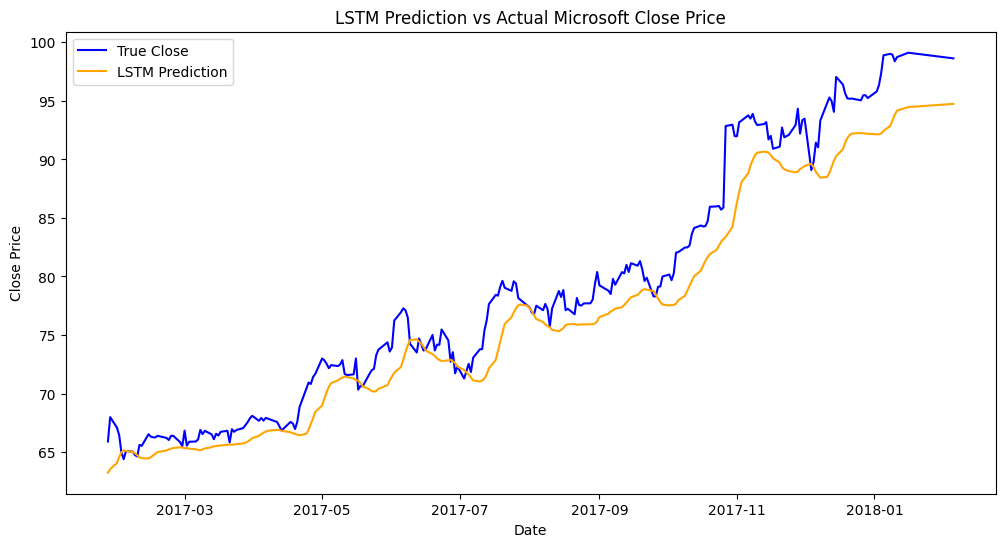

In [14]:
# LSTM Evaluation
from datetime import timedelta
lstm_pred = model.predict(X_test_lstm)
print("LSTM:")
print("  MAE:", mean_absolute_error(y_test_lstm, lstm_pred))
print("  RMSE:", np.sqrt(mean_squared_error(y_test_lstm, lstm_pred)))

# 7. Forecast Next 30 Days with LSTM (Recursive)
last_seq = close_series[-SEQ_LEN:]
future_preds_scaled = []
cur_seq = last_seq.copy()
for _ in range(30):
    pred = model.predict(cur_seq.reshape((1, SEQ_LEN, 1)))
    future_preds_scaled.append(pred[0,0])
    cur_seq = np.append(cur_seq[1:], pred[0,0])

# Inverse scale
futures_features = np.zeros((30, len(features))) # All features zero except close
futures_features[:,-1] = future_preds_scaled  # Set the last column (close) to scaled predictions
future_prices = scaler.inverse_transform(futures_features)[:,-1]

# Get the last date in your original dataframe
last_date = df.index[-1]
# Generate a list of next 30 dates (business days)
next_30_dates = pd.bdate_range(start=last_date + timedelta(days=1), periods=30)

# Make date-wise DataFrame
forecast_df = pd.DataFrame({
    'Date': next_30_dates,
    'Predicted_Close': future_prices
})
forecast_df.set_index('Date', inplace=True)

print("30-Day LSTM Date-wise Predictions:")
print(forecast_df)

# 8. Visualization of LSTM Prediction vs Actual
plt.figure(figsize=(12,6))
test_dates = df.index[-len(y_test_lstm):]
actual = scaler.inverse_transform(
    np.hstack([np.zeros((len(y_test_lstm), len(features) - 1)), y_test_lstm.reshape(-1,1)])
)[:,-1]
predicted = scaler.inverse_transform(
    np.hstack([np.zeros((lstm_pred.shape[0], len(features) - 1)), lstm_pred])
)[:,-1]
plt.plot(test_dates, actual, label='True Close', color='blue')
plt.plot(test_dates, predicted, label='LSTM Prediction', color='orange')
plt.title('LSTM Prediction vs Actual Microsoft Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()